In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
pd.set_option('display.max_rows', 100)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns

from utils import *

import sys
sys.path.append("../")

# Shows files

In [2]:
config_names = ["MESSI+\nSAX+\nSIMD",
               #"MESSI+\nSFA+ED",
               "MESSI+\nSFA+ED+\nSIMD",
               #"MESSI+\nSFA+EW",
               "MESSI+\nSFA+EW+\nSIMD"]

        
path = "logs/MESSI_SFA_logs"
all_files = read_logs(log_type="query", path=path, config_names = config_names)

Config logs/MESSI_SFA_logs/ASTRO/09
Queries 0 MESSI_QUERY_2024_06_20_15:53:48.csv ASTRO - gruenau1 - CPUs 09 MESSI_QUERY_2024_06_20_15:53:48.csv
Queries 1 MESSI_QUERY_2024_06_20_15:58:12.csv ASTRO - gruenau1 - CPUs 09 MESSI_QUERY_2024_06_20_15:58:12.csv
Queries 2 MESSI_QUERY_2024_06_20_16:01:00.csv ASTRO - gruenau1 - CPUs 09 MESSI_QUERY_2024_06_20_16:01:00.csv
Config logs/MESSI_SFA_logs/ASTRO/18
Queries 0 MESSI_QUERY_2024_06_20_17:52:46.csv ASTRO - gruenau1 - CPUs 18 MESSI_QUERY_2024_06_20_17:52:46.csv
Queries 1 MESSI_QUERY_2024_06_20_17:57:55.csv ASTRO - gruenau1 - CPUs 18 MESSI_QUERY_2024_06_20_17:57:55.csv
Queries 2 MESSI_QUERY_2024_06_20_18:00:24.csv ASTRO - gruenau1 - CPUs 18 MESSI_QUERY_2024_06_20_18:00:24.csv
Config logs/MESSI_SFA_logs/ASTRO/36
Queries 0 MESSI_QUERY_2024_06_05_12:51:39.csv ASTRO - gruenau1 - CPUs 36 MESSI_QUERY_2024_06_05_12:51:39.csv
Queries 1 MESSI_QUERY_2024_06_05_12:55:09.csv ASTRO - gruenau1 - CPUs 36 MESSI_QUERY_2024_06_05_12:55:09.csv
Queries 2 MESSI_QUER

In [3]:
query_times = pd.DataFrame(columns=["method", "querying time", "config", "dataset"])

i = 0
for ds_name, files in all_files.items():
    df_all = pd.DataFrame()
    for name, file in files.items():
        # print(file)
        df = pd.read_csv(file).iloc[:-1]  # last entry is the average        
        df["querying time"] = df["querying time"] / 1_000_000
        
        #print("Median:\t", name.replace("\n",""), "    \t", 
        #     np.round(df["querying time"].describe().loc["50%"], 3))  # * 10e-6

        df["method"] = name
        df["config"] = file.split("/")[3]
        df["dataset"] = file.split("/")[2]
        df_all = pd.concat([df_all, df], ignore_index=True)        
        query_times = pd.concat([query_times, df[["method", "querying time", "config", "dataset"]]], ignore_index=True)

        i = i+1
        
    df_all.rename(columns={"querying time" : "querying time in s"}, inplace=True)        

In [4]:
subset = query_times.rename(columns={
    "config":"Cores", "dataset": "Dataset", "method": "Method",
    "querying time" : "query time in s"})
# subset = subset[query_times.method.isin(["MESSI+\nSAX+\nSIMD", "MESSI+\nSFA+ED+\nSIMD", "MESSI+\nSFA+EW+\nSIMD"])]
subset = subset[query_times.method.isin(["MESSI+\nSAX+\nSIMD", "MESSI+\nSFA+EW+\nSIMD"])]


subset.Method.replace("MESSI+\nSAX+\nSIMD", "MESSI", inplace=True)
subset.Method.replace("MESSI+\nSFA+EW+\nSIMD", "SOFA", inplace=True)

subset

,Method,query time in s,Cores,Dataset
0,MESSI,0.008521,09,ASTRO
1,MESSI,0.008044,09,ASTRO
2,MESSI,0.006955,09,ASTRO
3,MESSI,0.006191,09,ASTRO
4,MESSI,0.006551,09,ASTRO
...,...,...,...,...
15295,SOFA,0.380433,36,TXED
15296,SOFA,0.573906,36,TXED
15297,SOFA,0.287192,36,TXED
15298,SOFA,0.388578,36,TXED


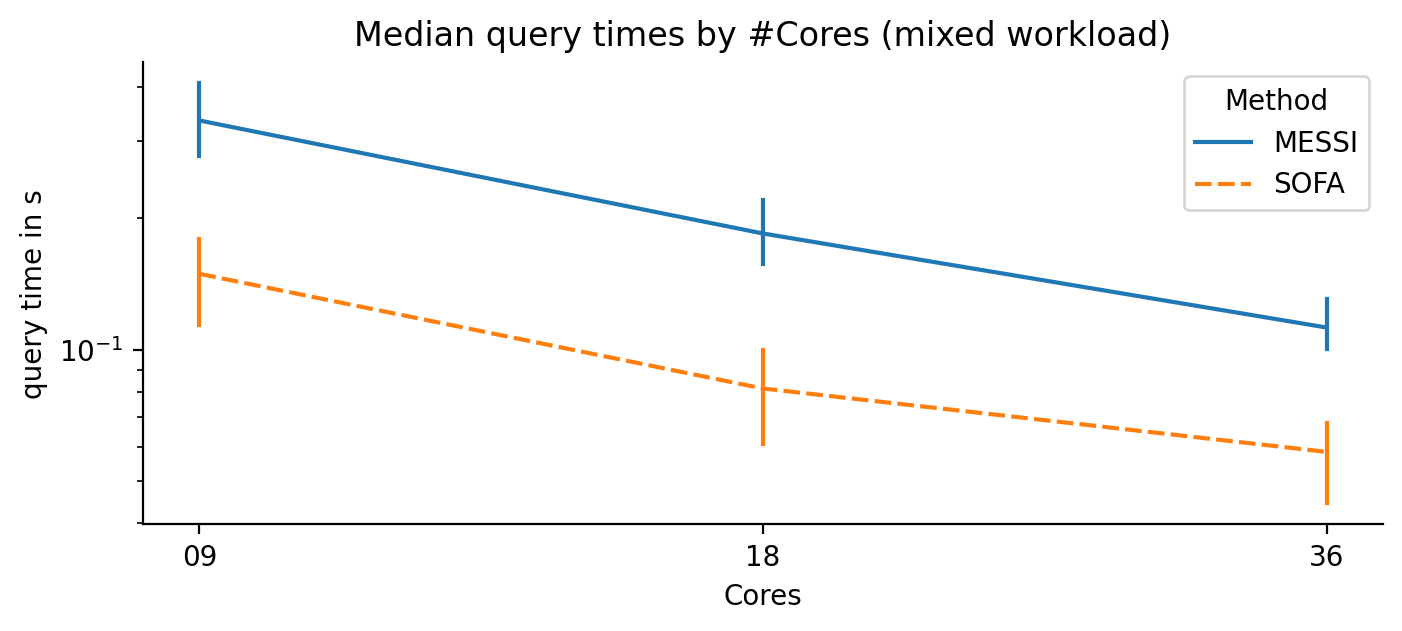

In [5]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(x="Cores", y="query time in s", hue="Method", estimator=np.median,  err_style="bars", 
             style="Method", data=subset, ax = ax, errorbar=('ci', 99))
ax.set_title("Median query times by #Cores (mixed workload)")
# ax.set_xticklabels(g.get_xticklabels(), rotation=-30)
ax.set_xlabel("Cores")
sns.despine()
plt.savefig("images/experiment_scalability_median_cores.pdf", bbox_inches='tight')
ax.set_yscale("log")
plt.show()

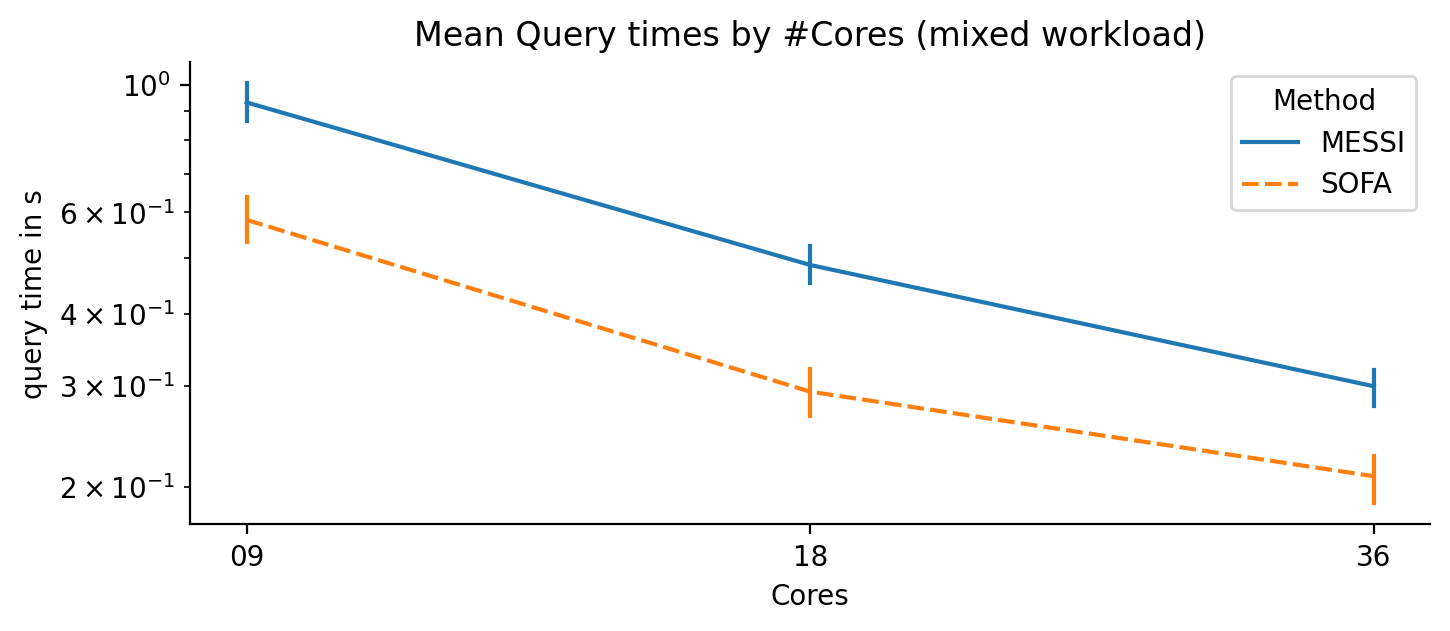

In [6]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(x="Cores", y="query time in s", hue="Method", estimator=np.mean,  err_style="bars", 
             style="Method", data=subset, ax = ax, errorbar=('ci', 99))
ax.set_title("Mean Query times by #Cores (mixed workload)")
# ax.set_xticklabels(g.get_xticklabels(), rotation=-30)
ax.set_xlabel("Cores")
sns.despine()
ax.set_yscale("log")
plt.savefig("images/experiment_scalability_mean_cores.pdf", bbox_inches='tight')
plt.show()

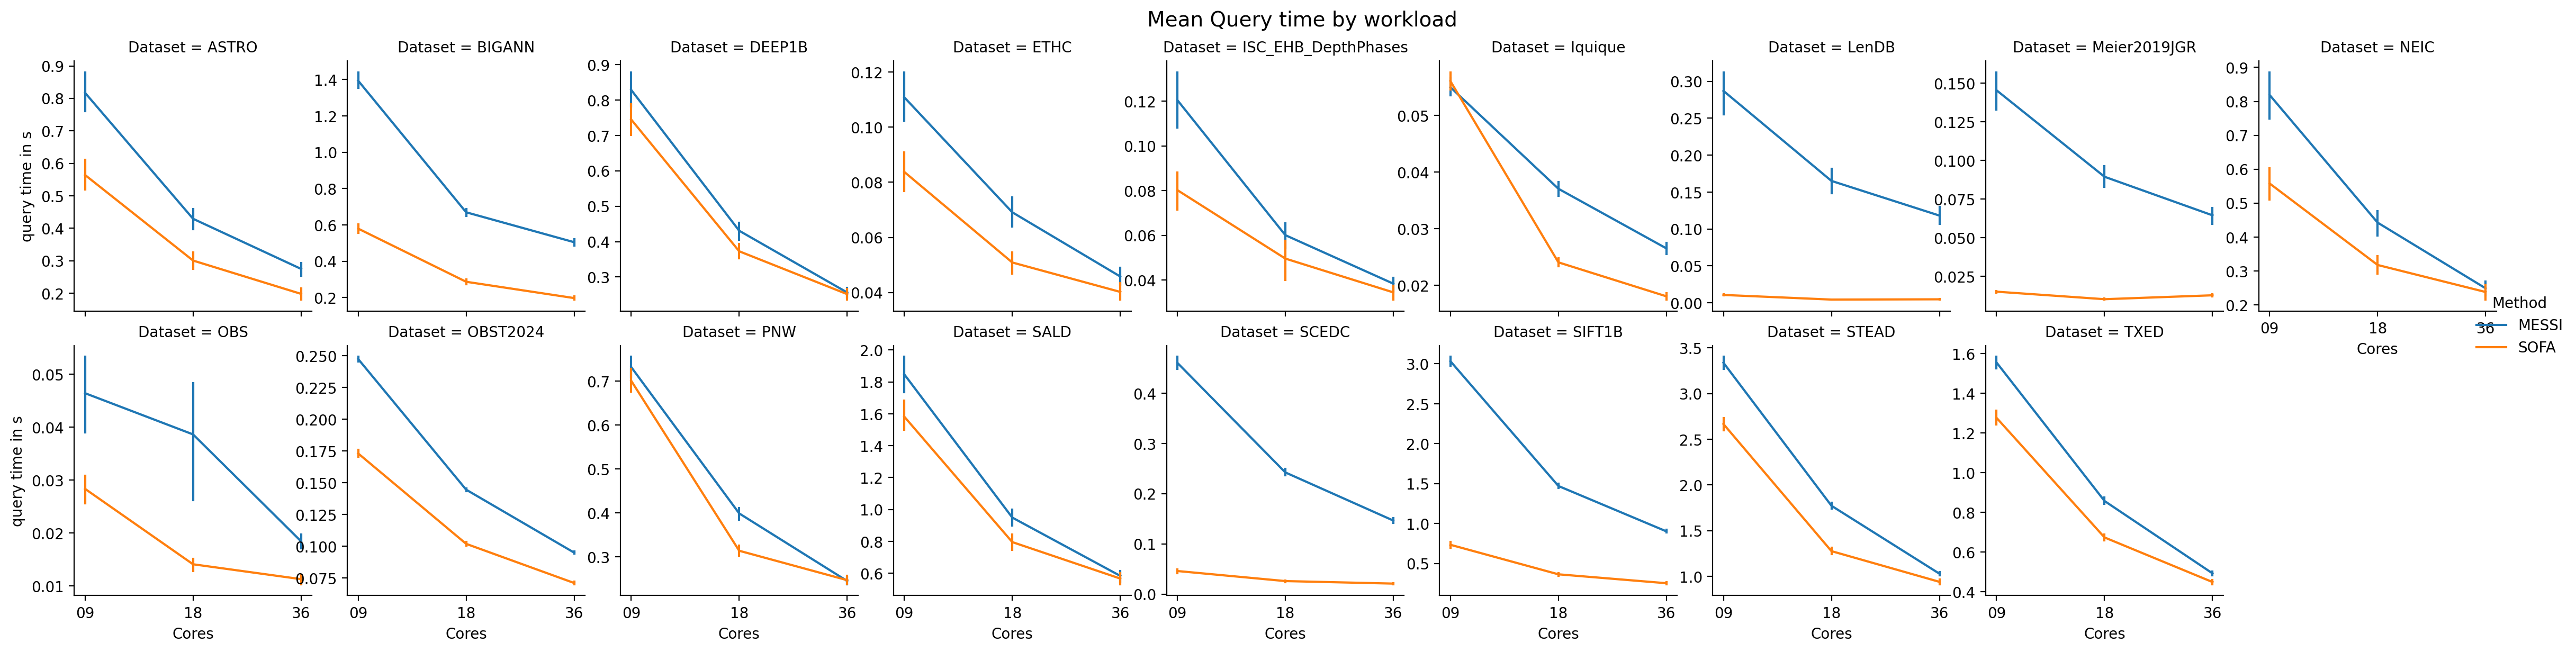

In [7]:
g = sns.relplot(x="Cores", y="query time in s", hue="Method", estimator=np.mean,  
                err_style="bars", 
             col="Dataset", col_wrap=9, facet_kws={'sharey': False, 'sharex': True}, legend="brief",
             data=subset, kind="line", errorbar=('ci', 50))
g.fig.set_figwidth(24)
g.fig.set_figheight(6)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Mean Query time by workload', size=14)
# g.set(yscale="log")
# g.set(title='Median Query time')
# g.ax.set_title("Average  Query time by #Cores")
# ax.set_xticklabels(g.get_xticklabels(), rotation=-30)
# ax.set_xlabel("Cores")
sns.despine()
# ax.set_yscale("log")
plt.savefig("images/experiment_scalability_mean_all.pdf", bbox_inches='tight')
plt.show()

In [8]:
#plot_order = subset.set_index("Method").groupby("Dataset").mean().sort_values(by="query time in s")
"""
plot_order = subset[subset.Cores=="09"].set_index("Dataset").sort_values(by=["Dataset", "Method"])
# display(plot_order)

fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="Dataset", 
            y="query time in s", 
            estimator=np.mean, 
            hue="Method", data=subset, ax = ax,
            order=plot_order.index)
ax.set_title("Mean query time in s by workload (lower is better)")
ax.set_xlabel("Dataset (workload)")
ax.set_ylabel("mean query time in s")
plt.xticks(rotation=-20, fontsize=10, ha='left')
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_yscale("log")
plt.savefig("images/experiment_experiment_mean_query_time.pdf", bbox_inches='tight')
plt.show()
"""

'\nplot_order = subset[subset.Cores=="09"].set_index("Dataset").sort_values(by=["Dataset", "Method"])\n# display(plot_order)\n\nfig, ax = plt.subplots(figsize=(16,6))\nsns.barplot(x="Dataset", \n            y="query time in s", \n            estimator=np.mean, \n            hue="Method", data=subset, ax = ax,\n            order=plot_order.index)\nax.set_title("Mean query time in s by workload (lower is better)")\nax.set_xlabel("Dataset (workload)")\nax.set_ylabel("mean query time in s")\nplt.xticks(rotation=-20, fontsize=10, ha=\'left\')\nsns.despine()\nsns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))\n#ax.set_yscale("log")\nplt.savefig("images/experiment_experiment_mean_query_time.pdf", bbox_inches=\'tight\')\nplt.show()\n'

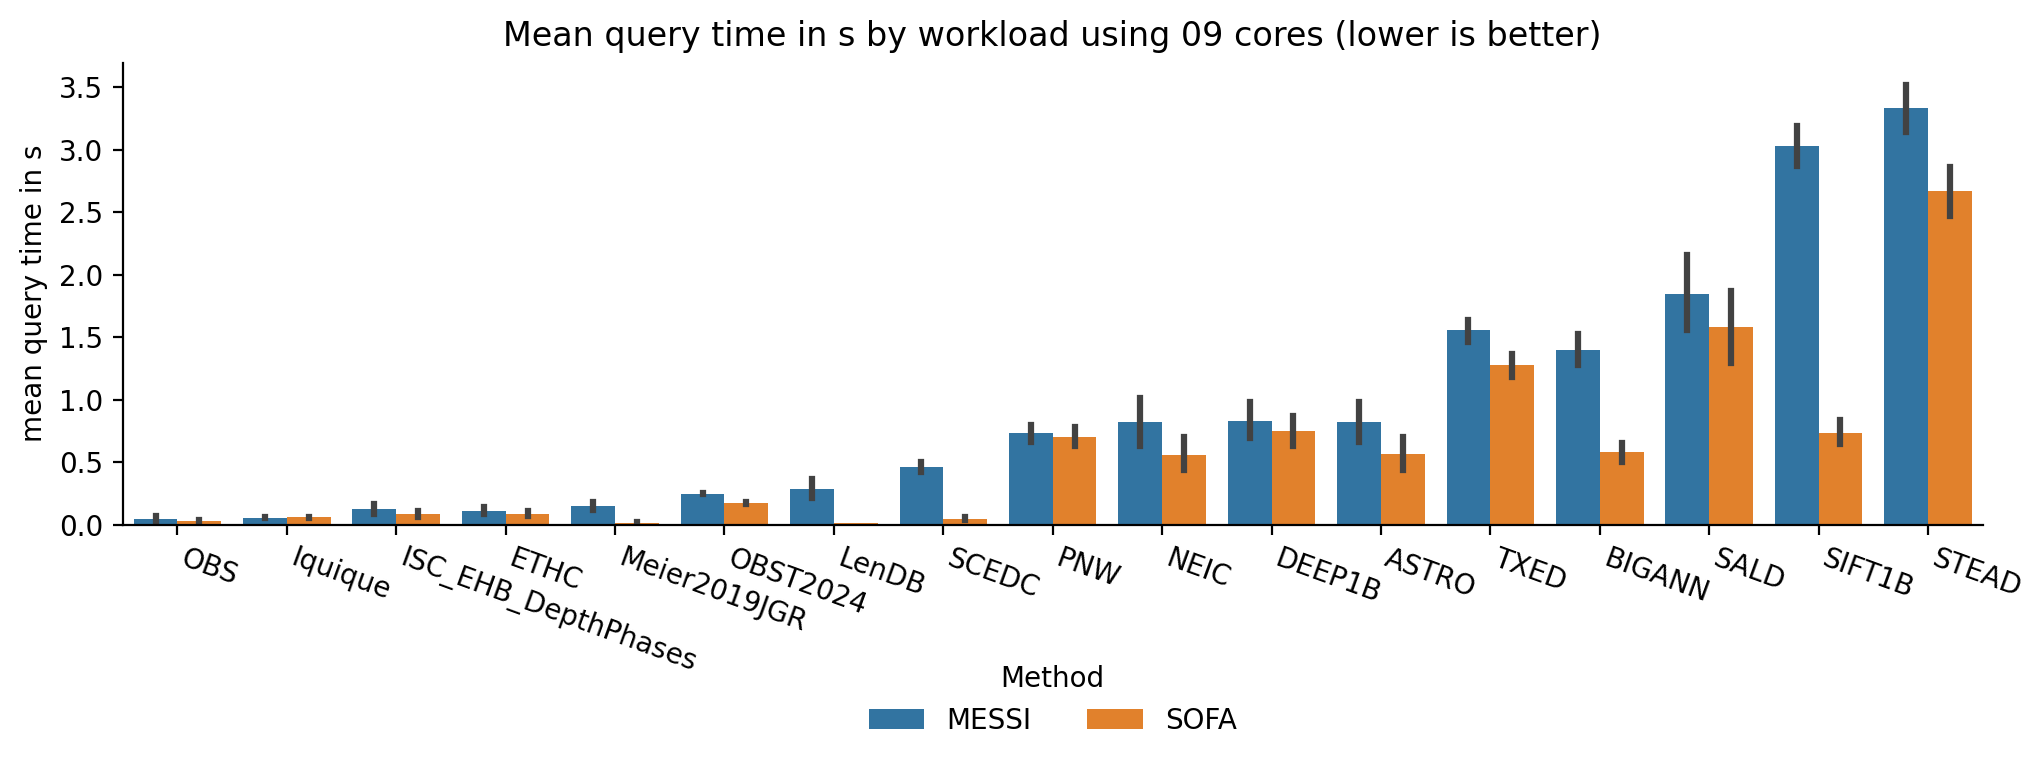

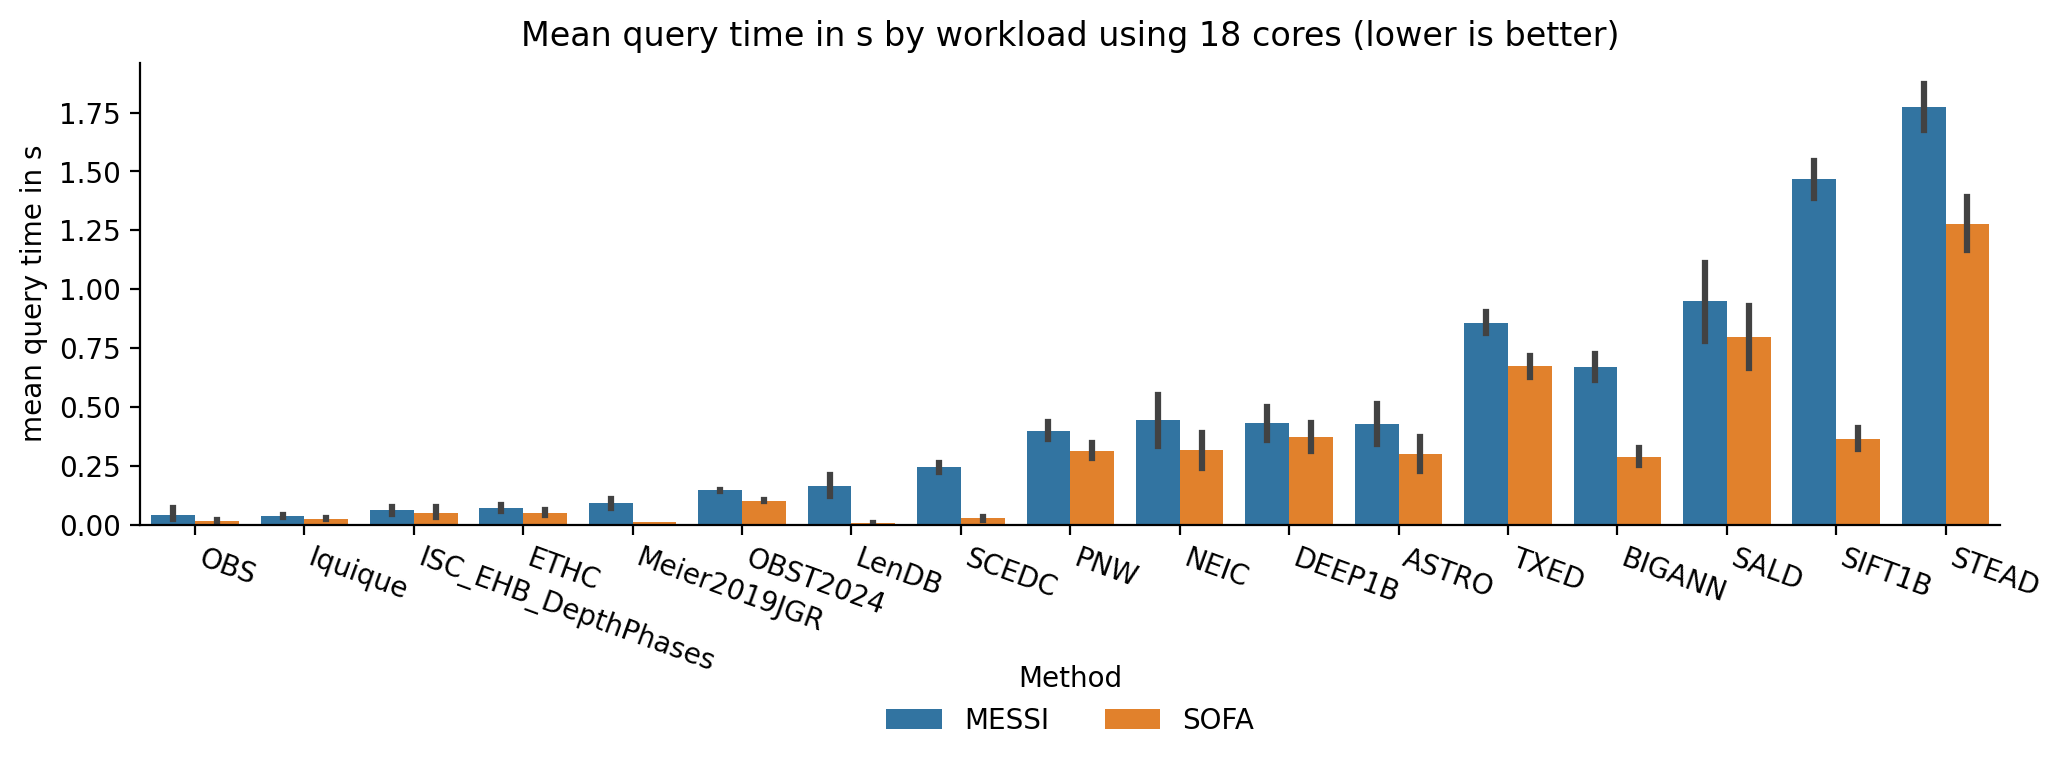

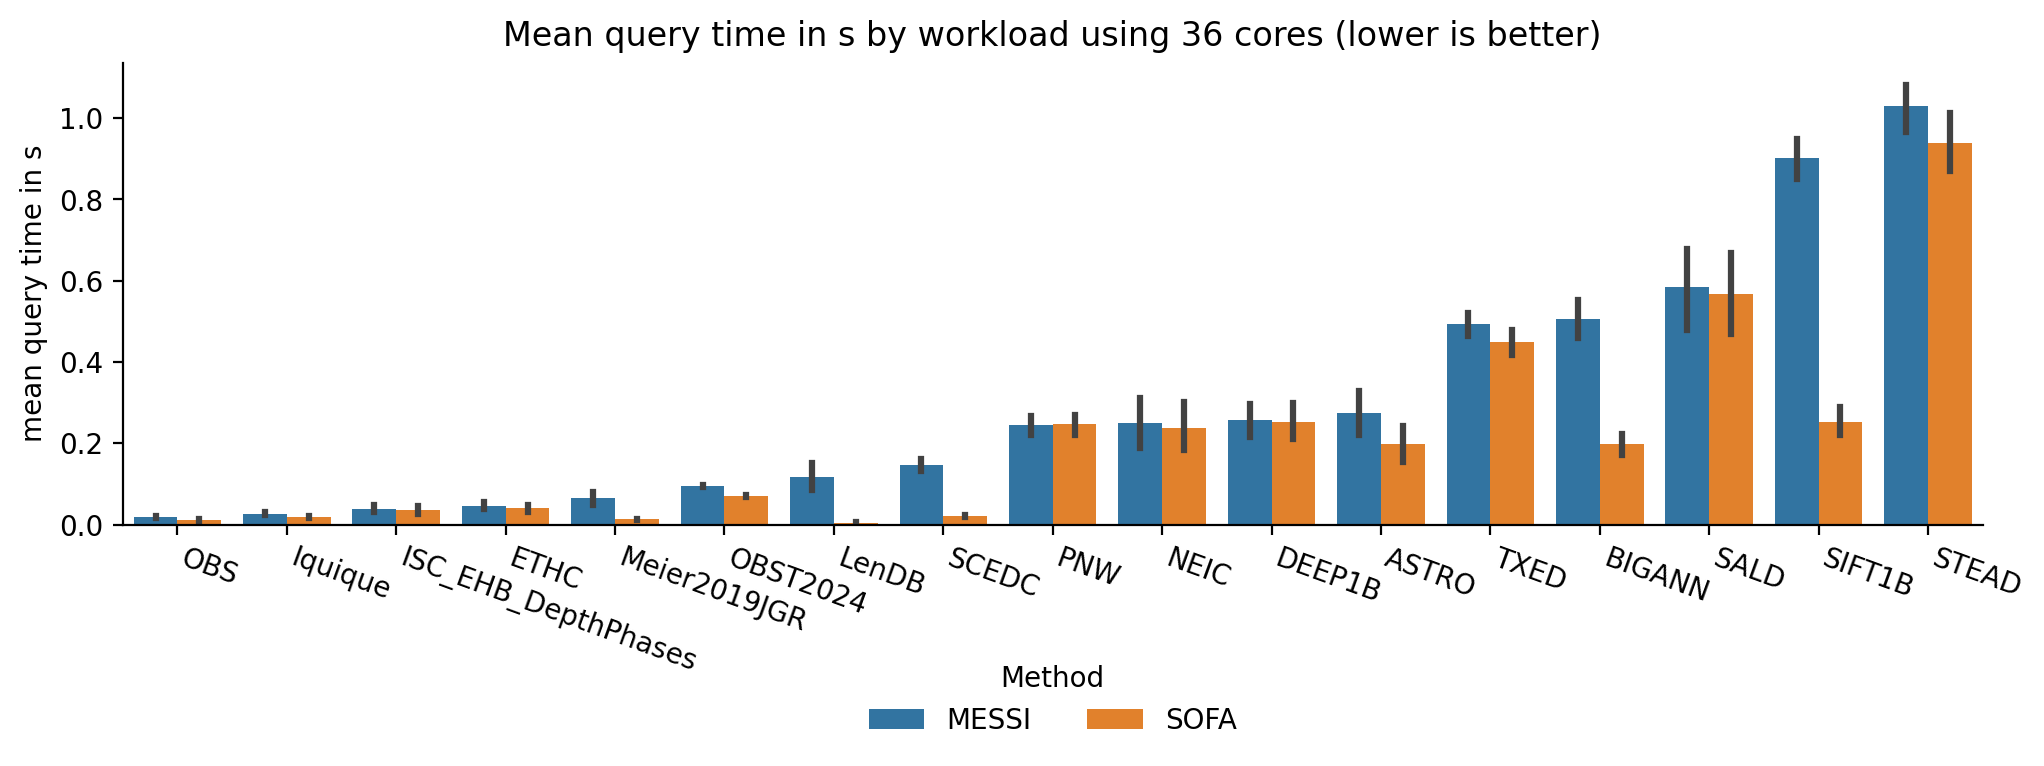

In [9]:
ALL_CORES = ["09", "18", "36"]

subset.Method = subset.Method.replace("\n","", regex=True)
for CORES in ALL_CORES:    
    plot_order = subset[(subset.Cores=="36") & (subset.Method=="MESSI")].groupby(["Dataset"]) \
            .mean("query time in s").sort_values(by="query time in s")
    
    fig, ax = plt.subplots(figsize=(12,3))
    sns.barplot(x="Dataset", 
                y="query time in s", 
                # estimator=np.mean, 
                hue="Method", data=subset[(subset.Cores==CORES)], ax = ax,
                order=plot_order.index
               )
    ax.set_title("Mean query time in s by workload using "+str(CORES)+" cores (lower is better)")
    # ax.set_xlabel("Dataset (workload)")
    ax.set_xlabel("")
    ax.set_ylabel("mean query time in s")
    plt.xticks(rotation=-20, fontsize=10, ha='left')
    sns.despine()
    sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.25), ncol=3)  # bbox_to_anchor=(1, 1), 
    #ax.set_yscale("log")
    plt.savefig("images/experiment_mean_query_time_"+CORES+".pdf", bbox_inches='tight')
    plt.show()

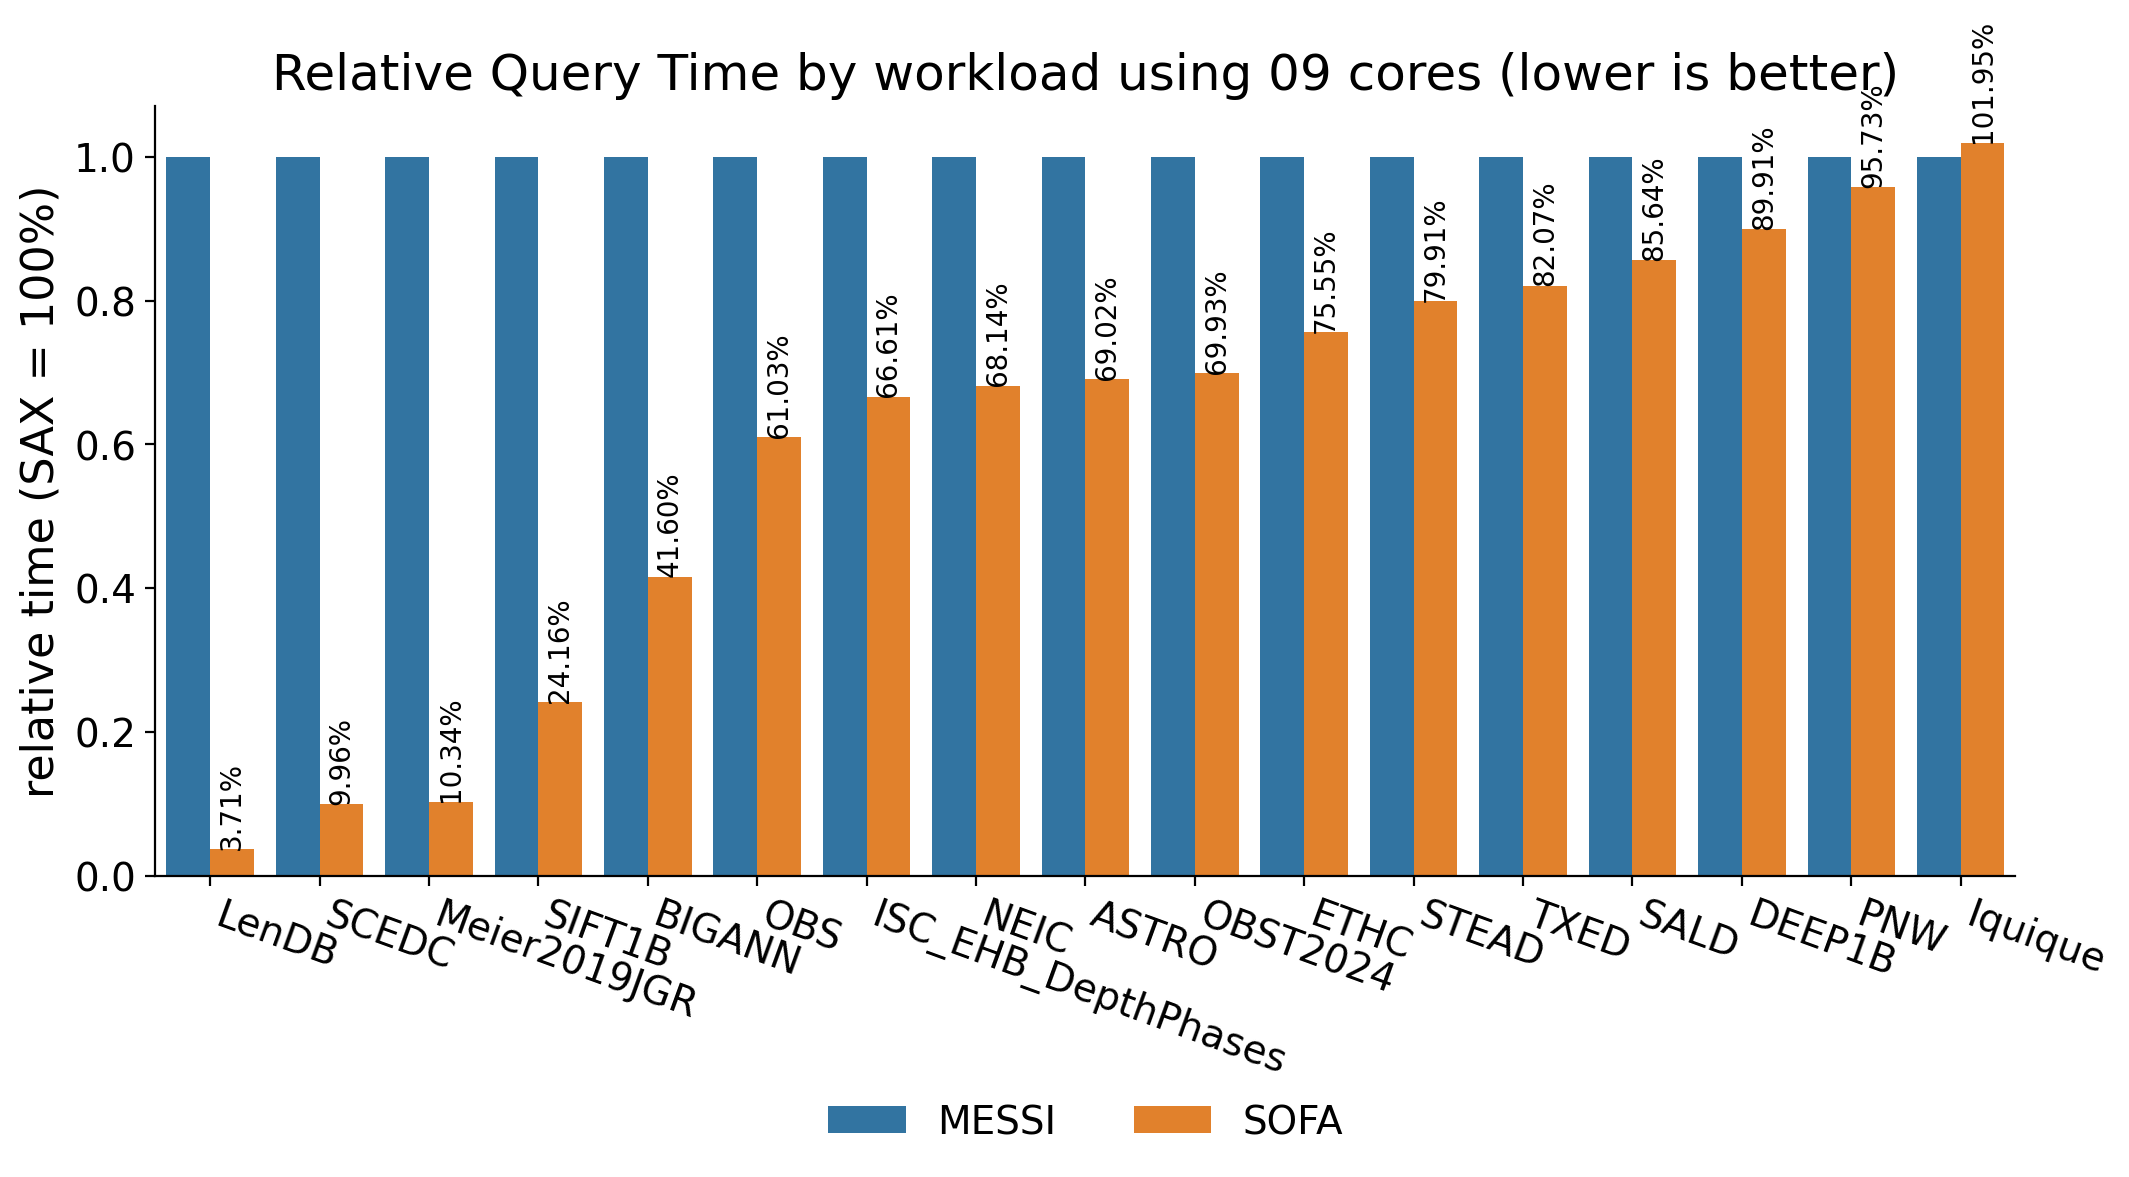

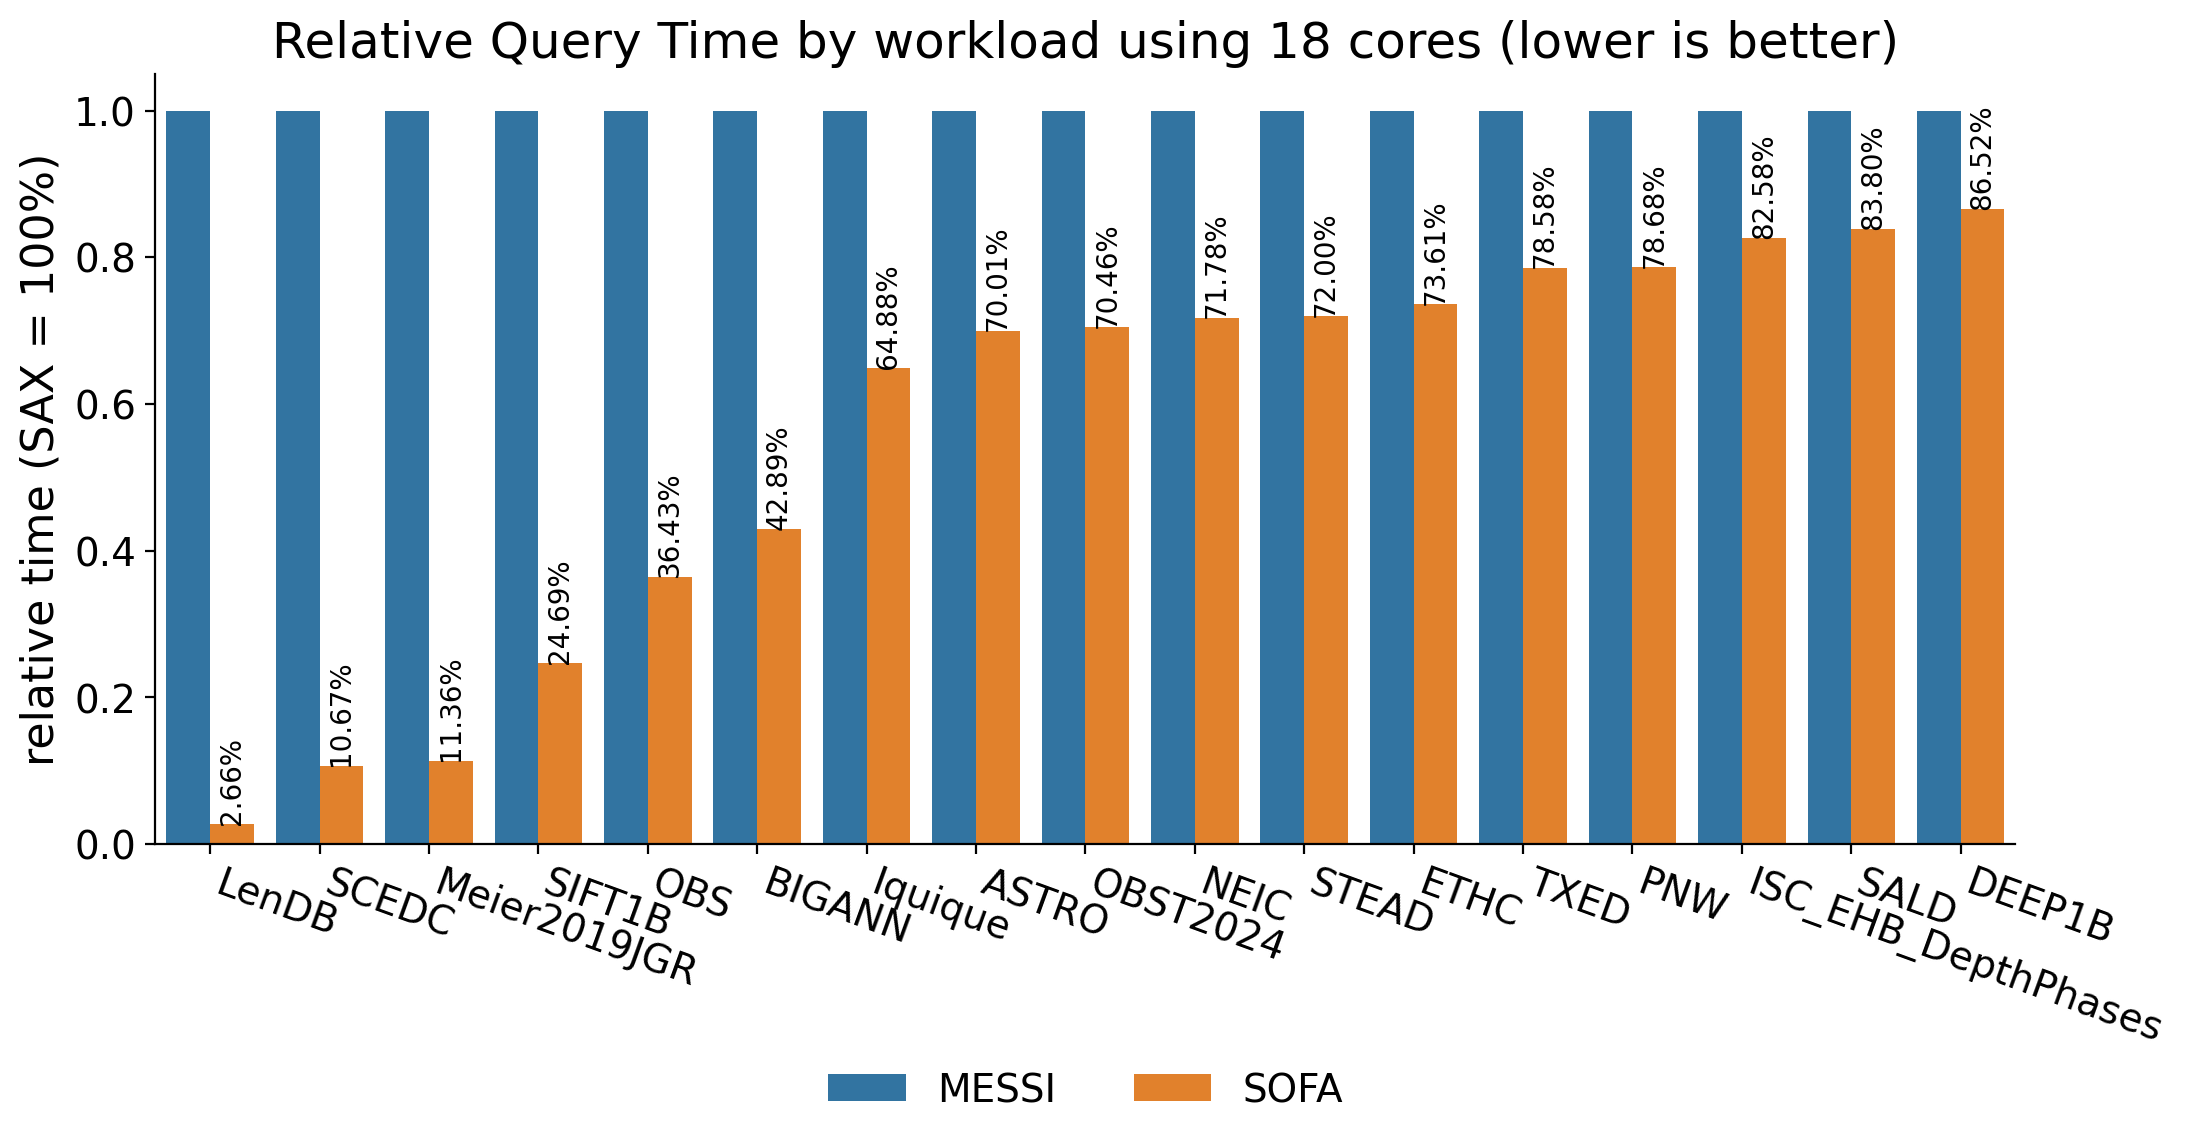

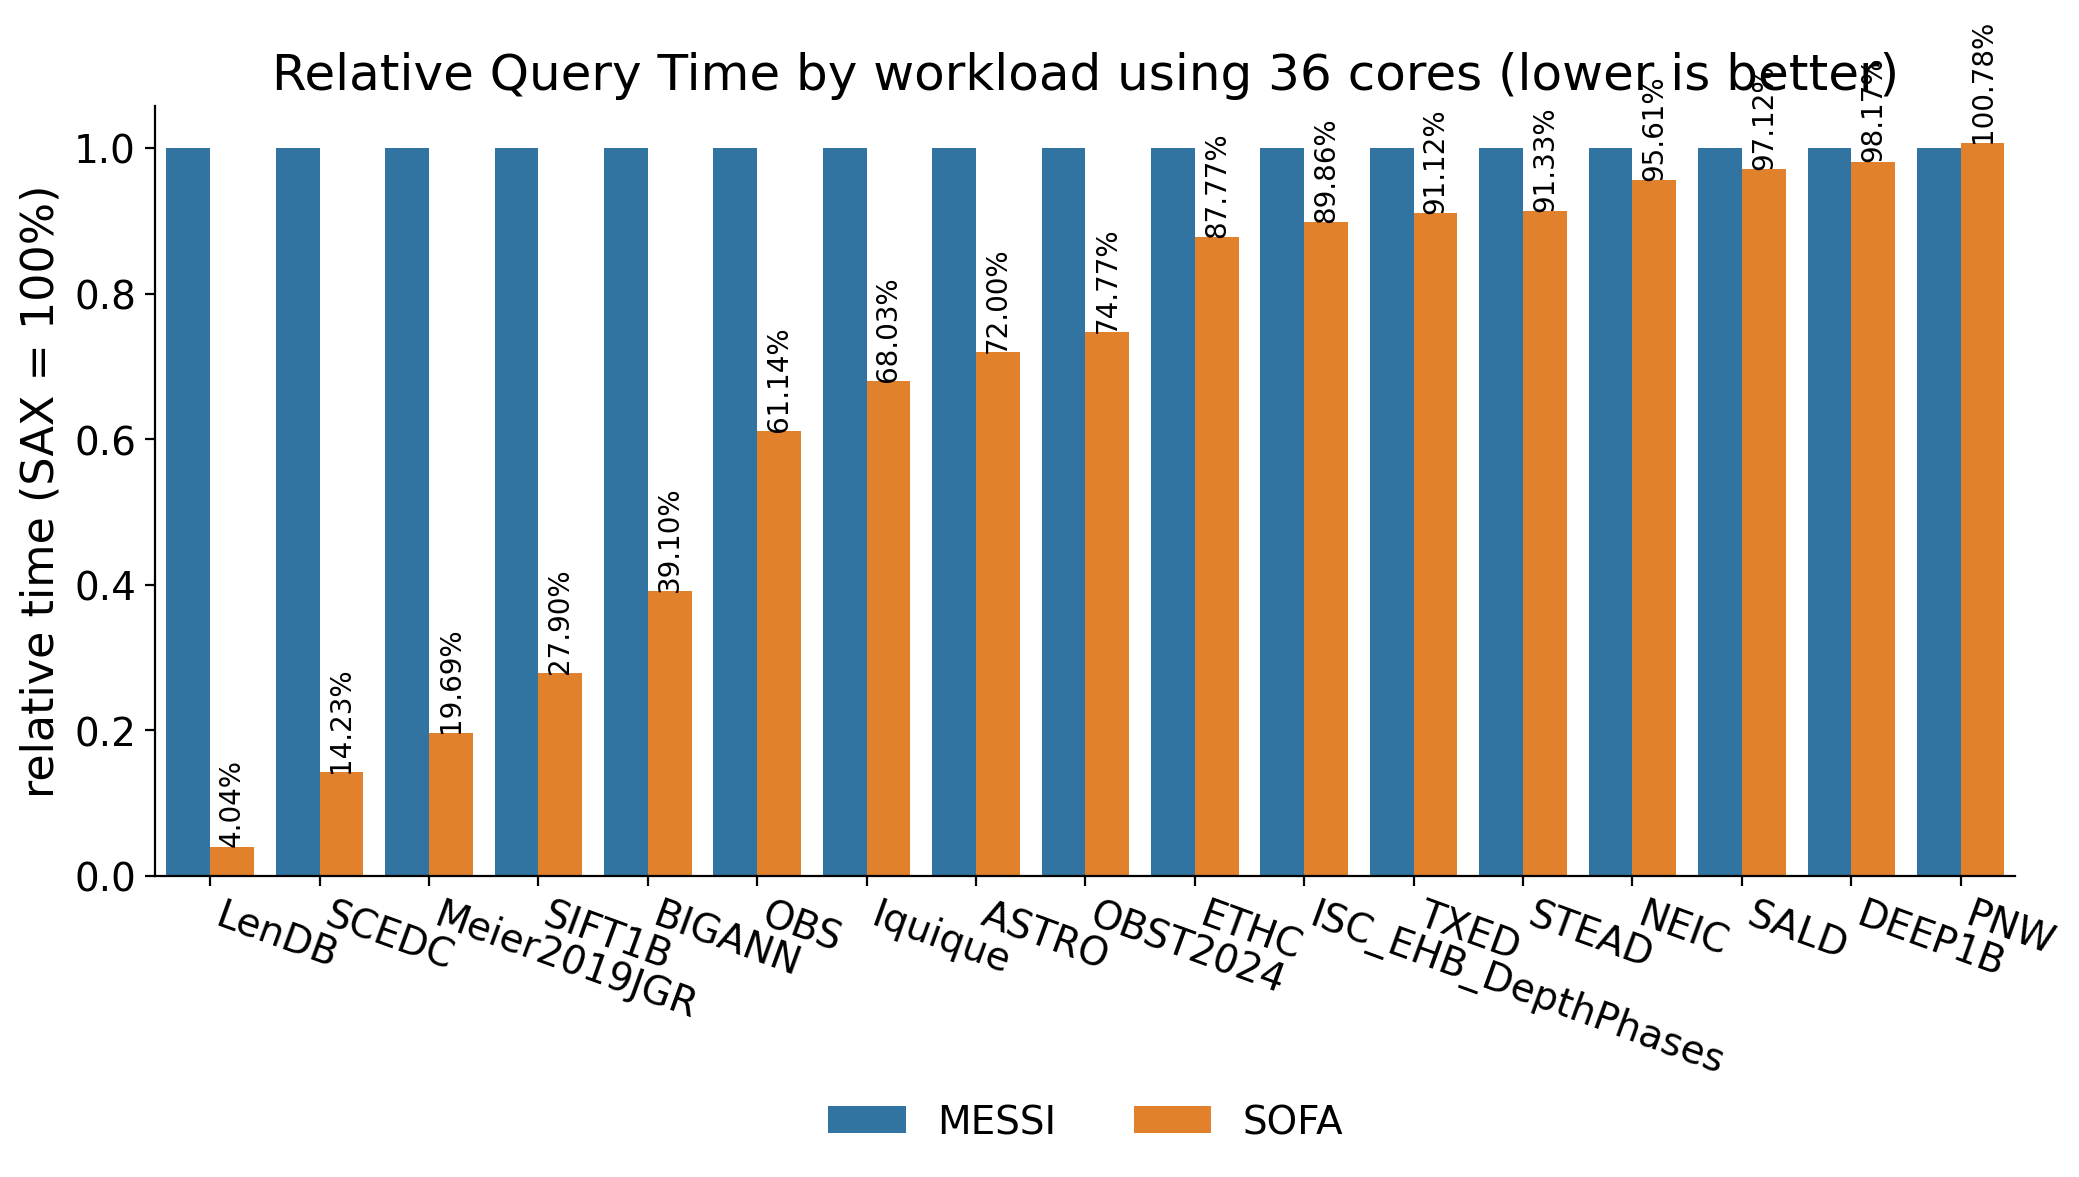

In [16]:
ALL_CORES = ["09", "18", "36"]

for CORES in ALL_CORES:    

    df_mean = subset[subset.Cores==CORES].groupby(["Dataset", "Method"])["query time in s"].sum().reset_index()
    
    # l.iloc[0]["query time in s"]
    df_normed = df_mean.groupby(["Dataset"]) \
            .apply(lambda l: l["query time in s"] / (l["query time in s"].iloc[0])).reset_index()
    
    df_factor = df_mean.groupby(["Dataset"]) \
            .apply(lambda l: (l["query time in s"].iloc[0]) / l["query time in s"]).reset_index()
    
    plot_order = df_normed.groupby("Dataset").min("query time in s").sort_values(by="query time in s")
    
    
    df_mean["normed"] = df_normed["query time in s"]
    df_mean["factor"] = df_factor["query time in s"]
    # display(df_mean)
    
    fig, ax = plt.subplots(figsize=(12,5))
    sns.barplot(x="Dataset", y="normed",
                hue="Method", data=df_mean, ax = ax,
                order=plot_order.index
               )

    legend = ax.legend() # removes the title
    ax.bar_label(ax.containers[1], fmt='{:.2%}', rotation=90, label_type='edge', fontsize=10)
    #ax.bar_label(ax.containers[2], fmt='{:.2%}', rotation=90)
    ax.set_title("Relative Query Time by workload using "+str(CORES)+" cores (lower is better)", fontsize=18)
    ax.set_xlabel("")
    ax.set_ylabel("relative time (SAX = 100%)", fontsize=16)
    plt.xticks(rotation=-20, fontsize=14, ha='left')
    plt.yticks(fontsize=14)
    sns.despine()
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.25), ncol=3, fontsize=14)
    plt.savefig("images/experiment_relative_query_time_"+CORES+".pdf", bbox_inches='tight')
    plt.show()
    
    
    # display(df_mean)

/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_87986/2032842176.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


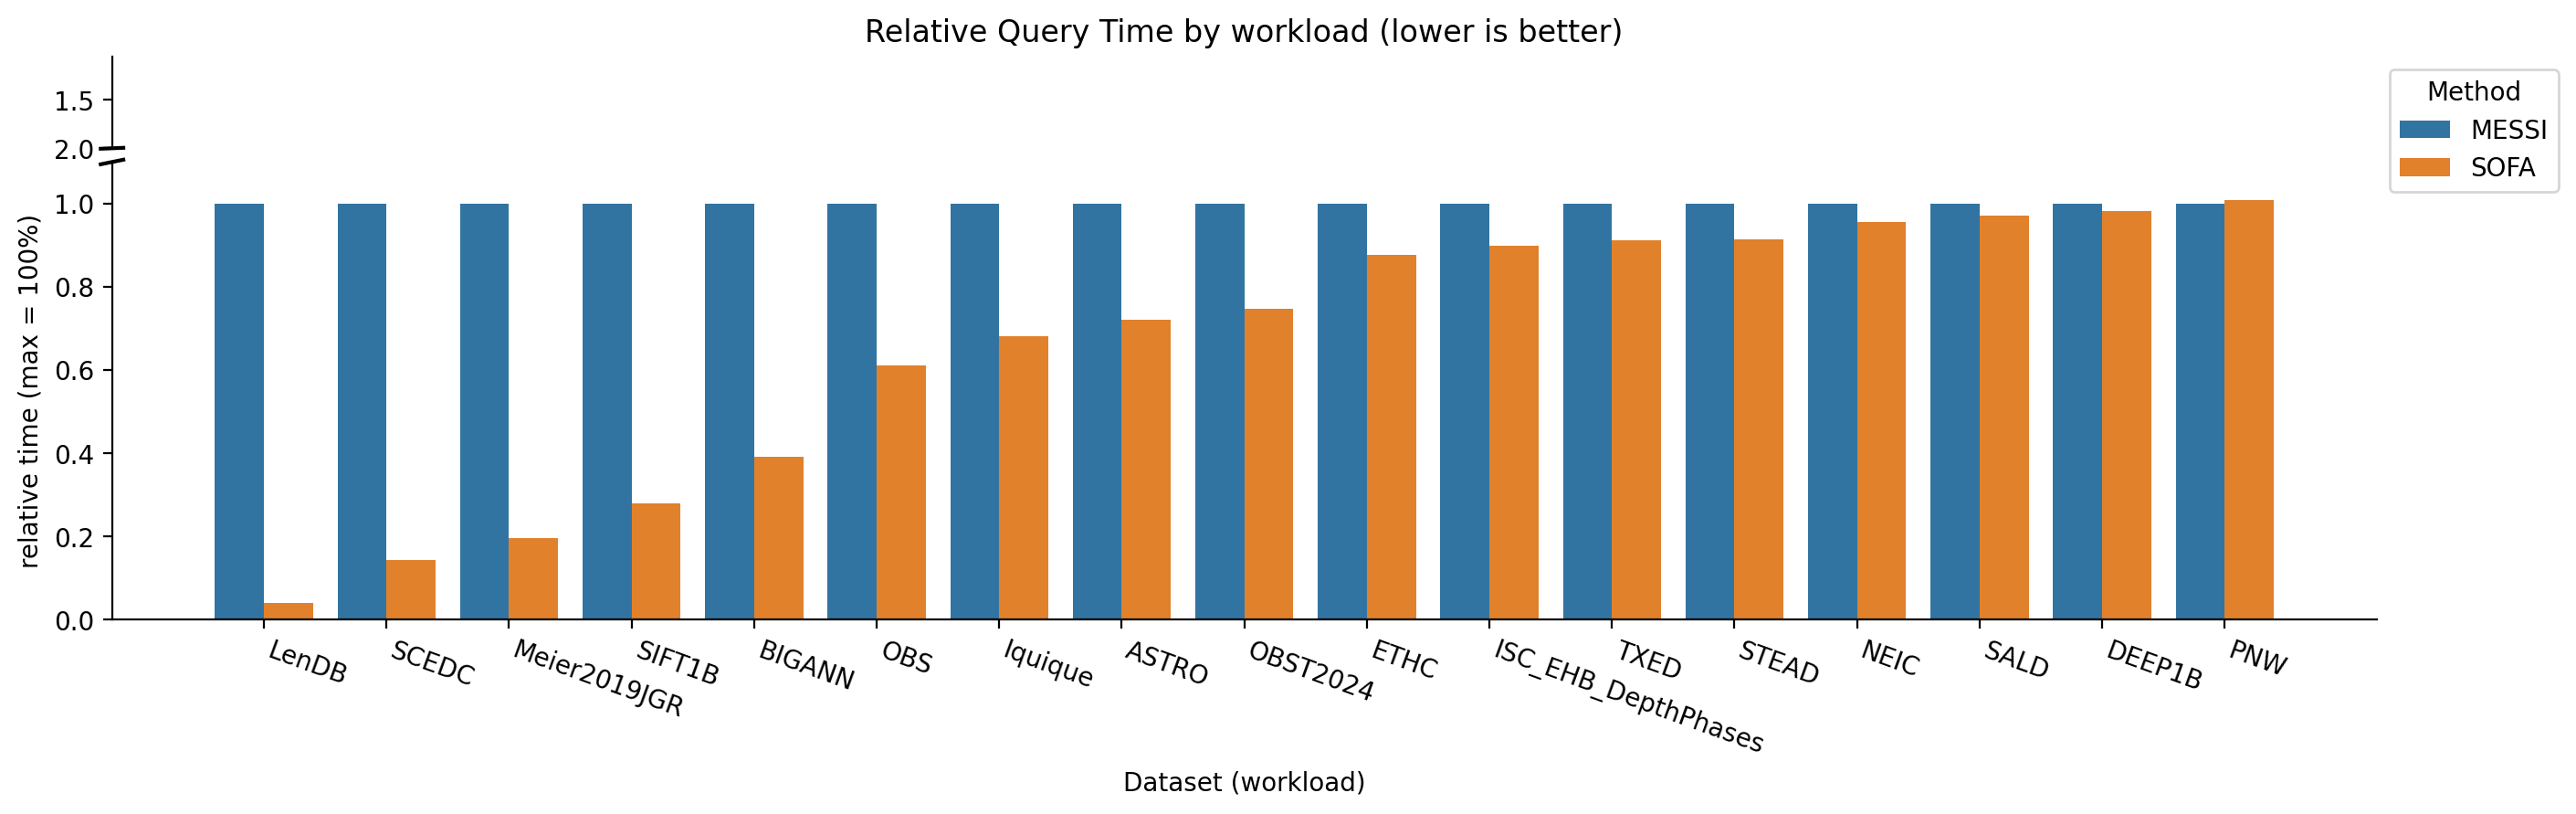

In [11]:
fig, (ax_top, ax_bottom) = plt.subplots(
    ncols=1, nrows=2, # sharex=True, 
    gridspec_kw={'hspace':0.05, 'height_ratios': [1, 5]}, figsize=(16,4))

sns.barplot(x="Dataset", y="normed", hue="Method", data=df_mean, ax = ax_top, order=plot_order.index)
sns.barplot(x="Dataset", y="normed", hue="Method", data=df_mean, ax = ax_bottom, order=plot_order.index)

ax_top.set_ylim(bottom=2.0)
ax_bottom.set_ylim(0, 1.1)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

d = .005
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)

kwargs.update(transform=ax_bottom.transAxes)  # switch to the bottom axes
ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)

#remove one of the legend
ax_bottom.legend_.remove()
ax_top.set_ylabel("")
ax_top.set_xlabel("")
ax_top.set_xticks([])

ax_top.set_title("Relative Query Time by workload (lower is better)")
ax_bottom.set_xlabel("Dataset (workload)")
ax_bottom.set_ylabel("relative time (max = 100%)")
plt.xticks(rotation=-20, fontsize=10, ha='left')
sns.move_legend(ax_top, "upper left", bbox_to_anchor=(1, 1))
# sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.25), ncol=3)  # bbox_to_anchor=(1, 1), 
plt.tight_layout()

# plt.savefig("images/experiment_relative_query_time.pdf", bbox_inches='tight')
# plt.show()

<Axes: xlabel='Cores', ylabel='query time in s'>

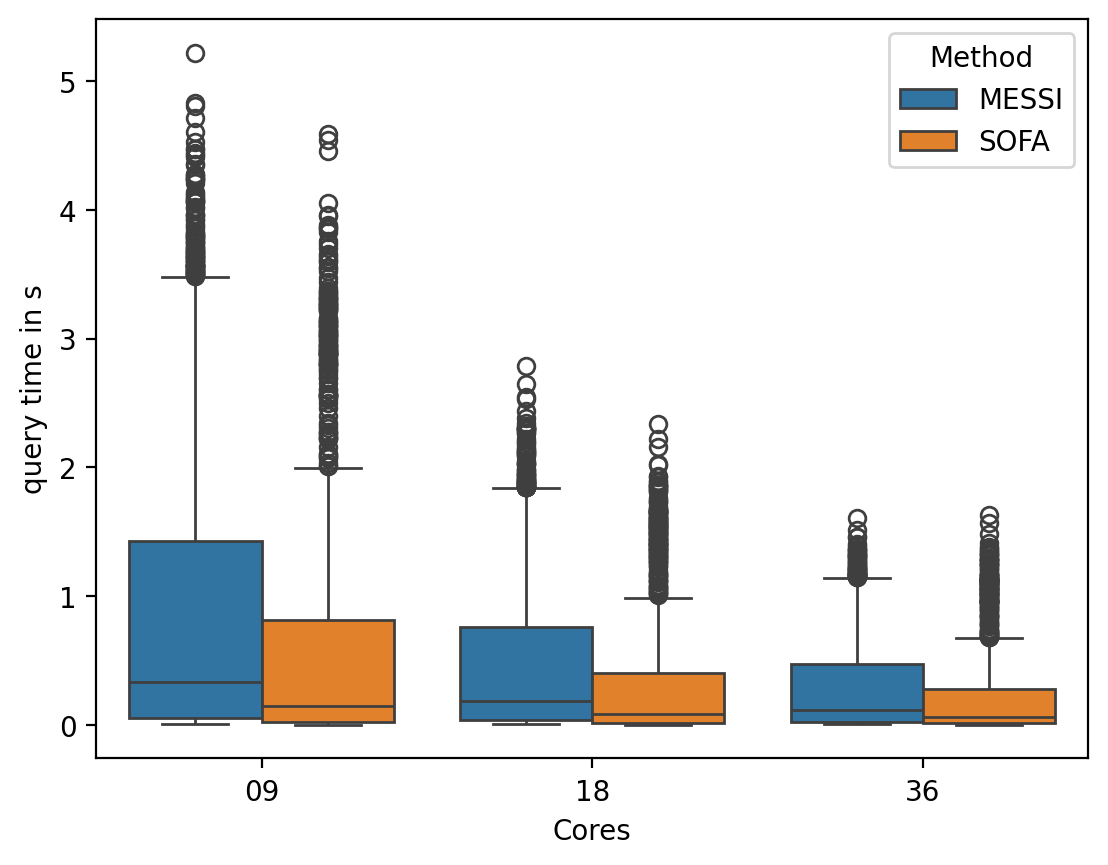

In [12]:
sns.boxplot(hue="Method", y="query time in s", x="Cores", data=subset)

In [13]:
result_median = subset.groupby(["Method","Cores"])["query time in s"].median().transform(lambda l: str(np.round(l * 1000))+" ms")
result_median

Method  Cores
MESSI   09       335.0 ms
        18       185.0 ms
        36       112.0 ms
SOFA    09       149.0 ms
        18        81.0 ms
        36        58.0 ms
Name: query time in s, dtype: object

In [14]:
result_mean = subset.groupby(["Method","Cores"])["query time in s"].mean().transform(lambda l: str(np.round(l * 1000))+" ms")
result_mean

Method  Cores
MESSI   09       932.0 ms
        18       486.0 ms
        36       299.0 ms
SOFA    09       582.0 ms
        18       293.0 ms
        36       209.0 ms
Name: query time in s, dtype: object

In [15]:
result_all = pd.concat([result_median, result_mean], axis=1)
print(result_all.T.to_latex())

\begin{tabular}{lllllll}
\toprule
Method & \multicolumn{3}{l}{MESSI} & \multicolumn{3}{l}{SOFA} \\
Cores &        09 &        18 &        36 &        09 &        18 &        36 \\
\midrule
query time in s &  335.0 ms &  185.0 ms &  112.0 ms &  149.0 ms &   81.0 ms &   58.0 ms \\
query time in s &  932.0 ms &  486.0 ms &  299.0 ms &  582.0 ms &  293.0 ms &  209.0 ms \\
\bottomrule
\end{tabular}



/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_87986/585941613.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_all.T.to_latex())
